In [320]:
"""
import modules
"""
from prepare_data import prepare_df_from_mac as prepare_data
from emulate_reduction import emulator_v2_MLR as emulate
from visualize_output import vis_emulator_v2 as v2_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

dir(emulate)

['CtaxRedEmulator',
 'LinearRegression',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'combi_df',
 'mean_squared_error',
 'minimize',
 'np',
 'pd',
 'plt',
 'r2_score',
 'train_test_split']

In [337]:
"""
load data
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_linear.dat'
FILENAME_CUBICROOT = 'costcurve_co2_linear.dat'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

In [4]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2050
region = 11
STEPSIZE_CTAX_PATH = 1  # stepsize the ctax path consists of so if 2 than 2,4,6...  


In [5]:
"""
prepare data using prepare_df

input: MAC sets (df), YEAR, REGION, STEPSIZE

output: ctax paths with reduction
"""

reload(prepare_data)

lin_reduction = prepare_data.reduction_df(df_linear, year, region)
cubic_reduction = prepare_data.reduction_df(df_cubic, year, region)
root_reduction = prepare_data.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_data.find_path(lin_reduction, STEPSIZE_CTAX_PATH, 'linear')
cubic_paths = prepare_data.find_path(cubic_reduction, STEPSIZE_CTAX_PATH, 'cubic')
root_paths = prepare_data.find_path(root_reduction, STEPSIZE_CTAX_PATH, 'cubicroot')

root_paths.tail()

,0,1,2,3,4,5,6,7,8,9,10,reduction
196,0.0,1819.502823,2292.429907,2624.177164,2888.280695,3111.306062,3306.256048,3480.583687,3639.005646,3784.718388,3920.0,89.5883
197,0.0,1828.786000,2304.125978,2637.565823,2903.016821,3127.180072,3323.124701,3498.341767,3657.572001,3804.028175,3940.0,89.6167
198,0.0,1838.069178,2315.822049,2650.954482,2917.752947,3143.054083,3339.993355,3516.099847,3676.138356,3823.337963,3960.0,89.6401
199,0.0,1847.352356,2327.518120,2664.343141,2932.489073,3158.928093,3356.862008,3533.857927,3694.704712,3842.647751,3980.0,89.6573
200,0.0,1856.635533,2339.214191,2677.731800,2947.225199,3174.802104,3373.730661,3551.616007,3713.271067,3861.957538,4000.0,89.6721


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v2_MLR.py:69: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]


weights dataframe: 
             0           1  ctax
0   21.084484  -70.791848   200
1   40.491451 -106.300083   400
2   -0.292342  -39.235220   600
3    5.008476  -28.619050   800
4   -8.675943   -3.922495  1000
5  -16.094854    8.154115  1200
6  -13.036240    1.680588  1400
7  -12.968288   -2.107888  1600
8  -12.681947   -0.794347  1800
9   -7.809284   -4.365916  2000
10  -5.353841   -4.434428  2200
11  -1.762948   -8.000201  2400
12  -1.525496   -8.252494  2600
13  -2.855526   -7.819753  2800
14  -4.162886   -7.435921  3000
15  -5.800585   -6.179378  3200
16   0.300507  -16.810623  3400
17   8.073714  -29.466237  3600
18   9.474002  -31.762456  3800
19  -1.866039   -0.667014  4000


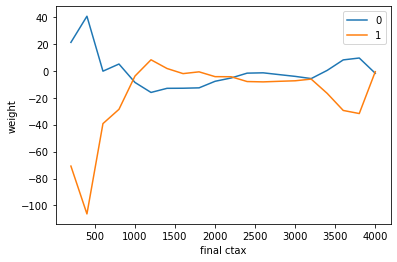

In [349]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# only for this emulator we use combination of paths tot train and test
combi_paths = emulate.combi_df(cubic_paths, root_paths, cubic_reduction, root_reduction)

x = emulate.CtaxRedEmulator(lin_paths, combi_paths)

x.train_ctax_path(10, 200, 2)

# do it for all remaining test paths
cubic_test = []
root_test = []
    
for i in range(1, len(root_paths), 2):
        
    cubic_test.append(x.test_ctax_path(root_paths.loc[i]))
    root_test.append(x.test_ctax_path(cubic_paths.loc[i+1]))
    


RMSE:  10.716259082686012
R-squared:  0.6207988399739675


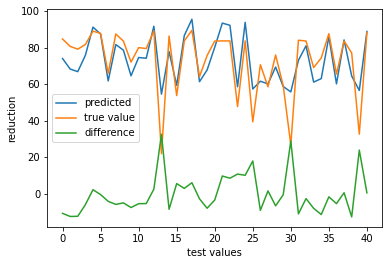

In [348]:
x.train_ctax_MLR()

In [227]:
root_paths.head()

,0,1,2,3,4,5,6,7,8,9,10,reduction
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0000
1,0.0,9.283178,11.696071,13.388659,14.736126,15.874011,16.868653,17.75808,18.566355,19.309788,20.0,22.4967
2,0.0,18.566355,23.392142,26.777318,29.472252,31.748021,33.737307,35.51616,37.132711,38.619575,40.0,24.5504
3,0.0,27.849533,35.088213,40.165977,44.208378,47.622032,50.605960,53.27424,55.699066,57.929363,60.0,26.8447
4,0.0,37.132711,46.784284,53.554636,58.944504,63.496042,67.474613,71.03232,74.265421,77.239151,80.0,28.8845


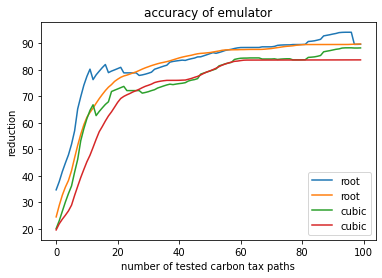

In [338]:
"""
Figures showing the emulated reduction vs real reduction

Also calculation of MSE

zelfde kleuren maar andere weergave
"""

reload(v2_plot)

v2_plot.emulator_v2_graphs(cubic_test, root_test)